# EXAMPLE 

For practical implementation:
https://scikit-learn.org/stable/auto_examples/linear_model/plot_polynomial_interpolation.html

For theoretical knowledge of spline:
https://timodenk.com/blog/cubic-spline-interpolation/


In [1]:
# Author: Mathieu Blondel
#         Jake Vanderplas
#         Christian Lorentzen
#         Malte Londschien
# License: BSD 3 clause

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures, SplineTransformer
from sklearn.pipeline import make_pipeline
import os
import matplotlib.lines as mlines


In [2]:

desktop = os.path.join(os.path.join(os.environ['USERPROFILE']), 'Desktop') 
#print(os.getcwd())
This_file_path = os.getcwd()
total_string_len = len(This_file_path)
#print(total_string_len)

string_len_to_remove = len("Data Examination")
#print(string_len_to_remove)

path = This_file_path[0:(total_string_len-string_len_to_remove)]
#print(path)
path_processed_data = path + "Processed_data\\"
#print(path_processed_data)

# Set up FCR-D forecast. Mean for the past 5 days.
- At D-2 it is past 5 days, meaning 7 days from what to predict.
- At D-1 it is the past 5 days, meaning 6 days from what to predict

In [3]:
data = pd.read_csv(path_processed_data + 'real.csv') # Change path
#print(data)
#data = data.fillna(0) 
#data_cop = data.copy()
data = data.drop(columns=["Hour"])
#setup_forecast = data_cop.drop(columns=["Hour"])
True_data = data.loc[8760:].reset_index(drop=True)
True_data_arr = True_data.to_numpy()
#Spot_data = True_data['Spot']


In [22]:
Forecast_number = [1]
Forecasts = ["Spot","FD1_down","FD2_down","FD1_up","FD2_up","FD1_up_percentage","FD2_up_percentage","FD1_down_percentage","FD2_down_percentage","FD_act_up","FD_act_down"]
Noise_factor = [0]
Total_length_test = len(data["FD1_down"]) - 8760

# Create an empty dataframe with the same columns as `data`
print(Total_length_test,len(Forecasts),len(Forecast_number))
forecasted_data_3D = np.zeros(( Total_length_test, len(Forecasts), len(Forecast_number) ))  # (Specific Forecasts, Data size, number of total forecasts )

print(np.shape(forecasted_data_3D))

2160 11 1
(2160, 11, 1)


In [23]:
h = 0
col = "FD1_up_percentage"
HD = [3,4,5,6,7]
for hd in HD:
    print(data.loc[h+8760-hd*24, col])

0.019946298427311
0.1574614065180103
0.1023413897280966
0.170522707797772
0.1460154241645244


In [24]:
index_FD1_up_percentage = Forecasts.index("FD1_up_percentage")
index_FD1_down_percentage = Forecasts.index("FD1_down_percentage")
std_col = np.std(data.loc[:, :],axis=0)
D_2_list = [3,4,5,6,7]

for col in data.columns:
    index = Forecasts.index(col) # Get the index

    for n, noise in enumerate(Noise_factor): # For each noise factor / forecast
    
    
        # Run mean procedure

        # As the volumes need to add up to 100% then is it only the D-1 which has been forecasted as t
        if 'percentage' in col:
                if "FD2" in col:
                    if "up" in col:
                        forecasted_data_3D[:,index,n] = 1 - forecasted_data_3D[:,index_FD1_up_percentage,n]
                    else:
                        forecasted_data_3D[:,index,n] = 1 - forecasted_data_3D[:,index_FD1_down_percentage,n]
                        #forecasted_data.loc[h, col] = 1 - forecasted_data.loc[h, 'FD1_down_percentage']
                else:
                    for h in range(0,Total_length_test):
                        value = 0
                        for hd in D_2_list:

                            #print(data.loc[h+8760-hd*24, col])
                            #print(h+8760-hd*24)
                            value = value + data.loc[h+8760-hd*24, col]
                        
                        forecasted_data_3D[h,index,n] = value/len(D_2_list)

        else:

            for h in range(0,Total_length_test):
                value = 0
                for hd in D_2_list:

                    #print(data.loc[h+8760-hd*24, col])
                    #print(h+8760-hd*24)
                    value = value + data.loc[h+8760-hd*24, col]
                
                forecasted_data_3D[h,index,n] = value/len(D_2_list)


    print("Forecasts for ", col, " ended")

            
    

Forecasts for  Spot  ended
Forecasts for  FD1_down  ended
Forecasts for  FD2_down  ended
Forecasts for  FD1_up  ended
Forecasts for  FD2_up  ended
Forecasts for  FD1_up_percentage  ended
Forecasts for  FD2_up_percentage  ended
Forecasts for  FD1_down_percentage  ended
Forecasts for  FD2_down_percentage  ended
Forecasts for  FD_act_up  ended
Forecasts for  FD_act_down  ended


In [35]:
print(np.shape(forecasted_data_3D[:,:]))
print(forecasted_data_3D[:,5])
#print(forecasted_data_3D[:,5,1])

(2160, 11, 1)
[[0.11925745]
 [0.08343594]
 [0.10093695]
 ...
 [0.19614269]
 [0.19702464]
 [0.19716236]]


In [36]:
Forecast_number = [1, 2, 3, 4, 5, 6]
N_len = np.size(forecasted_data_3D[:,:,:],2) # Number of forecasts
F_len = np.size(forecasted_data_3D[:,:,:],1) # Number of features
T_len = np.size(forecasted_data_3D[:,:,:],0) # length of test data
Saved_Info = np.zeros((N_len,F_len ,(1+1+1+1) ) ) # Number of different forecast noise, Features and col = (noise type, MAE, MedianEA, Std) 
F = data.columns
for n in range(0,N_len): # For each forecast factor

    for f in range(0,F_len): # For each type of forecast, spot, FD2 Down so forth..

        errors = (True_data_arr[:,f] - forecasted_data_3D[:,f,n])

        MAE_h  =np.abs(errors)
        #MAPE_h = np.abs( (errors) / (True_data_arr[:,f]) ) * 100
        
        #MAPE = np.mean(MAPE_h)
        MAE = np.mean(MAE_h)
        
        #Median_APE = np.median(MAPE_h)
        Median_AE = np.median(MAE_h)

        #Std_APE = np.std(MAPE_h)
        Std_AE = np.std(MAE_h)
    


        
        #df_describe = pd.DataFrame(MAPE_h)
        #print("         ", "Noise factor", " Feature","    Mean    ","        Median        ", "      Std      ")
        #print("Forecast-", Forecast_number[n], "-", Noise_factor[n],"    ",F[f],"   ", np.round(MAE), " ", np.round(Median_AE), " ", np.round(Std_AE))
        #print()
            
        # Save the proper data
        Saved_Info[n,f,0] = n 
        Saved_Info[n,f,1] = MAE
        Saved_Info[n,f,2] = Median_AE
        Saved_Info[n,f,3] = Std_AE


#print(Saved_Info)


for n in range(0,N_len):
    print("Forecast ",n, "    ",F[0],"(",np.round(Saved_Info[n,0,1]), np.round(Saved_Info[n,0,2]), np.round(Saved_Info[n,0,3]),")", "   ",F[1],"(",np.round(Saved_Info[n,1,1]), np.round(Saved_Info[n,1,2]), np.round(Saved_Info[n,1,3]),")", "   ",F[2],"(",np.round(Saved_Info[n,2,1]), np.round(Saved_Info[n,2,2]), np.round(Saved_Info[n,2,3]),")", "   ",F[3],"(",np.round(Saved_Info[n,3,1]), np.round(Saved_Info[n,3,2]), np.round(Saved_Info[n,3,3]),")", "   ",F[4],"(",np.round(Saved_Info[n,4,1]), np.round(Saved_Info[n,4,2]), np.round(Saved_Info[n,4,3]),")")



Forecast  0      Spot ( 51.0 46.0 34.0 )     FD1_down ( 46.0 8.0 113.0 )     FD2_down ( 6.0 2.0 10.0 )     FD1_up ( 18.0 10.0 27.0 )     FD2_up ( 3.0 2.0 3.0 )


## plotting the error

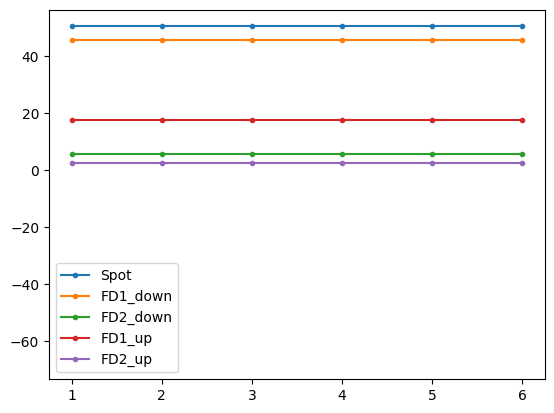

In [42]:
x = np.array(Forecast_number)

# plot for each feature
for f in range(0,F_len-6):
    
    MAE_f = Saved_Info[:,f,1]
    std_f = Saved_Info[:,f,3]
    plt.plot(x, MAE_f, label=F[f], marker='.')
    plt.fill_between(x, MAE_f-std_f, MAE_f-std_f, alpha=0.2)

plt.legend()
plt.show()

## Plot the hourly mean method

# Create a csv file for forecasted values of D-2

In [37]:

Noise_factor = [0.1, 0.5, 1, 2, 4, 8]
Forecast_number = [1, 2, 3, 4, 5, 6]
N_len = np.size(forecasted_data_3D[:,:,:],2)
F_len = np.size(forecasted_data_3D[:,:,:],0)
Saved_Info = np.zeros((N_len,F_len ,(1+1+1+1) ) ) # Number of different forecast noise, Features and col = (noise type, MAE, MedianEA, Std) 
F = data.columns
for n in range(0,N_len): # For each forecast factor

    # change forecasted_data_3D to a dataframe
    df_forecast = pd.DataFrame(forecasted_data_3D[:,:,n], columns=F)
    
    #Create csv
    csv_name_path = path_processed_data+"forecast"+str(Forecast_number[n])+".csv"
    df_forecast.to_csv(csv_name_path,index=False)